In [1]:
import qctoolkit as qtk
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import clear_output
import re
from datetime import datetime
import qmnet_model as qnm
import qmnet_tools as qnt
import tensorflow as tf

%matplotlib inline

clear_output()

In [2]:
from horton import GOBasisFamily
#basis = GOBasisFamily('basis', filename='basis/sto2g/H_Ne_uncontracted.nwchem')
#basis = '3-21g'
#basis = 'sto-3g'
#basis = GOBasisFamily('H_He_basis', filename='basis/sto6g/H_Ne.nwchem')
basis = GOBasisFamily('H_He_basis', filename='basis/sto6g/H_Be-s.nwchem')

resolution = 0.005
batch_size = 30000

In [3]:
molstr_list = [
    'HH',
    'HHe+',
    'HLi',
    'HBe+',
    'HeHe',
    'HeLi+',
    'HeBe',
    'LiLi',
    'LiBe+',
    'BeBe',
]

In [4]:
inp_grp = []
#inp_dump = []
for molstr in molstr_list:
    if '+' in molstr:
        charge = 1
    elif '-' in molstr:
        charge = -1
    else:
        charge = 0
    alist = re.findall('[A-Z][a-z]*', molstr)
    Zs = [qtk.n2Z(a) for a in alist]
    inp_list = []
    inp_grp.append(inp_list)
    #inp_dump.append(inp_list)
    res = resolution
    for R in np.arange(0.3, 4.0 + res, res):
        mol = qtk.Molecule()
        ZR = [[Zs[0], 0,0,0], [Zs[1], R, 0, 0]]
        mol.build(ZR)
        mol.charge = charge
        mol.name = mol.name + '_%s' % str(R)
        inp = qtk.QMInp(mol, program='horton', basis_set=basis, scf_step=30)
        try:
            inp.run()
            D, U = np.linalg.eigh(inp.olp)
            inp.X = U / np.sqrt(D)
            
            # to save inps into pickle file
            #inp.delete_ht_types()
            #inp.delete_matrices()
            
            inp_list.append(inp)
        except:
            pass
    print "%s finished" % mol.name
print [len(inp) for inp in inp_grp]

H2_4.0 finished
H1He1_4.0 finished
H1Li1_4.0 finished
H1Be1_4.0 finished
He2_4.0 finished
He1Li1_4.0 finished
He1Be1_4.0 finished
Li2_4.0 finished
Li1Be1_4.0 finished
Be2_4.0 finished
[741, 741, 741, 563, 741, 741, 741, 741, 741, 741]


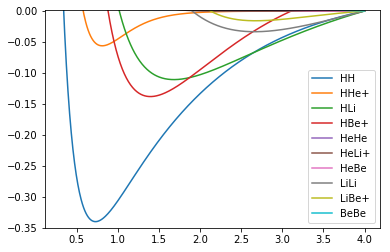

In [5]:
for i in range(len(inp_grp)):
    inp = inp_grp[i]
    E = np.array([o.Et for o in inp])
    E = E-E[-1]
    R = [o.molecule.R[1,0] for o in inp]
    #print E
    plt.plot(R, E, label=molstr_list[i])
plt.ylim(-0.35, 0.001)
plt.legend()

In [6]:
inp = inp_grp[0][5]
I_np, Er_np, occ, nn = qnt.get_input_tensor(inp)
C = inp.ht_exp_alpha.coeffs.__array__()
print qnt.get_output(I_np, Er_np, occ, nn, C)
print inp.Et

-0.730430578246
-0.730430578246


In [7]:
reload(qnt)
inp_train, inp_test, inp_valid = qnt.train_test_valid(inp_grp, 0, [0])
# print len(inp_train), len(inp_test), len(inp_valid)
I_train, Er_train, occ_train, nn_train, C_train, y_train = qnt.tfIO_batch(inp_train, batch_size)
I_test, Er_test, occ_test, nn_test, C_test, y_test = qnt.tfIO_batch(inp_test, batch_size)
I_valid, Er_valid, occ_valid, nn_valid, C_valid, y_valid = qnt.tfIO_batch(inp_valid, batch_size)

I_valid2, Er_valid2, occ_valid2, nn_valid2, C_valid2, y_valid2 = qnt.tfIO(inp_valid, [1,3,5])
print I_valid2.shape
print I_test[0].shape
print I_train[0].shape
print qnt.validation_inds(inp_valid)

(3, 7, 4, 4)
(75, 7, 4, 4)
(666, 7, 4, 4)
(43, 86, 413, 740)


In [39]:
reload(qnt)
reload(qnm)
reload(qnm.qnl)

def train(qmnet_model, root_name='model', learn_rate_min=0.0001, valid_ind=2, 
          train_list=range(len(inp_grp)), print_step=5, save_step=1000,
          threshold=1E-3, maxiter=100000, from_scratch=False,
          learn_rate_steps=50, learn_rate_start=0.1, learn_rate_base=0.5,
          batch_size=32, random_seed=0, max_mean_ratio=50.,
         ):
    
    def log_msg(msg, output=True):
        log.write(msg)
        log.flush()
        if output:
            print msg
    
    #####################################
    # TRAINING/TESTING/VALIDATION SETUP #
    #####################################
    inp_train, inp_test, inp_valid = qnt.train_test_valid(inp_grp, valid_ind, train_list, random_seed)
    I_train, Er_train, occ_train, nn_train, C_train, y_train = qnt.tfIO_batch(inp_train, batch_size)
    I_test, Er_test, occ_test, nn_test, C_test, y_test = qnt.tfIO_batch(inp_test, batch_size)
    I_valid, Er_valid, occ_valid, nn_valid, C_valid, y_valid = qnt.tfIO_batch(inp_valid, batch_size)
    i_rep, i_min, i_mid, i_max = qnt.validation_inds(inp_valid)
    v_inds = [i_rep, i_min, i_mid, i_max]
    I_valid2, Er_valid2, occ_valid2, nn_valid2, C_valid2, y_valid2 = qnt.tfIO(inp_valid, inds=v_inds)
    
    #################
    # STATUS REPORT #
    #################
    status = "root name: " + root_name + "\n"
    status += "model: " + str(qmnet_model) + "\n"
    status += "train/test/validation size: %d/%d/%d \n" % (len(inp_train), len(inp_test), len(inp_valid))
    status += "batch size: " + str(I_train[0].shape[0]) + "\n"
    status += "number of batches: " + str(len(I_train)) + "\n"
    status += "training set: " + str([molstr_list[i] for i in train_list]) + "\n"
    status += "validation: " + molstr_list[valid_ind] + "\n"
    status += "learning rate min: " + str(learn_rate_min) + "\n"
    status += "learning rate steps: " + str(learn_rate_steps) + "\n"
    status += "learning rate start: " + str(learn_rate_start) + "\n"
    status += "learning rate base: " + str(learn_rate_base) + "\n"
    status += "print step: " + str(print_step) + "\n"
    status += "threshold: " + str(threshold) + "\n"
    status += "maxiter: " + str(maxiter) + "\n"
    status += "execuate time: " + datetime.now().strftime("%Y/%m/%d %H:%M:%S") + "\n\n"
    
    log = open("%s.log" % root_name, 'w')
    log_msg(status)

    tf.reset_default_graph()
    g = tf.Graph()
    with g.as_default():
        
        # setup model variables
        y = tf.placeholder(tf.float64, name='y')
        y_prd, C_prd, param = qmnet_model(g, inp_valid[0].olp.shape[0])
        I, Er, occ, nn, keep_prob = param
        err_mean = tf.reduce_mean(tf.pow(y - y_prd, 2))
        err_max = tf.reduce_max(tf.pow(y - y_prd, 2))
        #err = err_mean + err_max
        err = err_mean
        optimizer, learn_rate, n_epoch = qnt.get_optimizer(
            g, err, learn_rate_steps, learn_rate_start, learn_rate_base, learn_rate_min
        )
        C_out = C_prd

        saver = tf.train.Saver()
        save_path = "%s.ckpt" % root_name

        sess = tf.Session()
        try:
            train_err_hist = []
            test_err_hist = []
            valid_err_hist = []
            C_valid_hist = []
            C_test_hist = []
            learn_rate_hist = []

            if not from_scratch:
                # load history and continue 
                try:
                    saver.restore(sess, save_path)
                    train_err_hist, test_err_hist, valid_err_hist, C_valid_hist, C_test_hist, learn_rate_hist = \
                    qtk.load('%s_hist.pkl' % root_name)
                    msg = 'model and history loaded, continue optimizing'
                except:
                    sess.run(tf.global_variables_initializer())
                    msg = 'no model found, or reload failed, start from scratch'
            else:
                msg = 'start from scratch...'
                sess.run(tf.global_variables_initializer())
                
            log_msg(msg + "\n")
            epoch = len(test_err_hist)
            
            test_err, train_err = 1, 1
            while (test_err > threshold or train_err > threshold) and epoch < maxiter:

                ############
                # TRAINING #
                ############
                # parse training set to optimizer and update model #
                train_err_list = []
                train_max_list = []
                train_mean_list = []
                for I_b, Er_b, occ_b, nn_b, C_b, y_b in \
                zip(I_train, Er_train, occ_train, nn_train, C_train, y_train):
                    train_dict = {I:I_b, Er:Er_b, occ:occ_b, nn:nn_b, y:y_b, keep_prob:0.8, n_epoch:epoch}
                    sess.run(optimizer, feed_dict=train_dict)
                    train_err_list.append(sess.run(err, feed_dict=train_dict))
                train_err = np.array(train_err_list).max()
                train_err_hist.append(train_err)
                current_learn_rate = sess.run(learn_rate, feed_dict=train_dict)
                learn_rate_hist.append(current_learn_rate)
                
                ###########
                # TESTING #
                ###########
                # parse test set to model to check test set error
                test_err_list = []
                for I_t, Er_t, occ_t, nn_t, C_t, y_t in zip(I_test, Er_test, occ_test, nn_test, C_test, y_test):
                    test_dict = {I:I_t, Er:Er_t, occ:occ_t, nn:nn_t, y:y_t, keep_prob:1.0}
                    test_err_list.append(sess.run(err, feed_dict=test_dict))
                test_err = np.array(test_err_list).max()
                test_err_hist.append(test_err)

                test2_dict = {
                    I:I_test[0][:3], 
                    Er:Er_test[0][:3], 
                    occ:occ_test[0][:3], 
                    nn:nn_test[0][:3], 
                    y:y_test[0][:3],
                    keep_prob:1.0
                }
                C_test_hist.append(np.array(sess.run(C_out, feed_dict=test2_dict)))

                ##############
                # VALIDATION #
                ##############
                # check validation performance
                valid_err_list = []
                for I_v, Er_v, occ_v, nn_v, C_v, y_v in \
                zip(I_valid, Er_valid, occ_valid, nn_valid, C_valid, y_valid):
                    valid_dict = {I:I_v, Er:Er_v, occ:occ_v, nn:nn_v, y:y_v, keep_prob:1.0}
                    valid_err_list.append(sess.run(err, feed_dict=valid_dict))
                valid_err = np.array(valid_err_list).max()
                valid_err_hist.append(valid_err)

                valid2_dict = {I:I_valid2, Er:Er_valid2, occ:occ_valid2, nn:nn_valid2, y:y_valid2}
                C_valid_hist.append(np.array(sess.run(C_out, feed_dict=valid2_dict)))

                #################
                # STATUS REPORT #
                #################
                epoch = len(test_err_hist)
                msg = "epoch: %5d train/test/validatoin error: %f/%f/%f at rate %f" % \
                (epoch, train_err, test_err, valid_err, current_learn_rate)

                log_msg(msg + "\n", False)

                if epoch % print_step == 0:
                    print msg
                    qtk.save([train_err_hist, test_err_hist, valid_err_hist, 
                              C_valid_hist, C_test_hist, learn_rate_hist], 
                             "%s_hist.pkl" % root_name)
                if epoch % save_step == 0:
                    print msg
                    qtk.save([train_err_hist, test_err_hist, valid_err_hist, 
                              C_valid_hist, C_test_hist, learn_rate_hist], 
                             "%s_hist.pkl" % root_name)
                    save_path_out = saver.save(sess, save_path)
                    msg = "Model and history backup"
                    log_msg(msg + "\n")

            ######################
            # TERMINATE AND SAVE #
            ######################
            save_path_out = saver.save(sess, save_path)
            msg = "Model saved in file: %s" % save_path_out
            log_msg(msg + "\n")
            qtk.save([train_err_hist, test_err_hist, valid_err_hist, C_valid_hist, C_test_hist, learn_rate_hist], 
                     "%s_hist.pkl" % root_name)
            print "optimization history saved"
            log.close()
            sess.close()
            print "session and log file closed"

        except KeyboardInterrupt:
            ######################
            # TERMINATE AND SAVE #
            ######################
            new_msg = "keyboard interrupt, current stage: %s" % msg
            log_msg(new_msg + "\n")
            save_path_out = saver.save(sess, save_path)
            msg = "Model saved in file: %s" % save_path_out
            log_msg(msg + "\n")
            qtk.save([train_err_hist, test_err_hist, valid_err_hist, C_valid_hist, C_test_hist, learn_rate_hist], 
                     "%s_hist.pkl" % root_name)
            print "optimization history saved"
            log.close()
            sess.close()
            print "session and log file closed"

In [43]:
lr = 0.01
const_lr = {
    'learn_rate_start':lr, 
    'learn_rate_min':lr, 
    'learn_rate_base':1.0, 
}
vary_lr_H2 = {
    'learn_rate_start':0.005, 
    'learn_rate_min':0.00001, 
    'learn_rate_steps':200, 
    'learn_rate_base':0.8
}

vary_lr = {
    'learn_rate_start':lr, 
    'learn_rate_min':0.000001, 
    'learn_rate_steps':500, 
    'learn_rate_base':0.9
}

reload(qnm)
#qm_model = qnm.Ix0_dS5x5_O3x5
#qm_model = qnm.I3_S3O3x5d_S3O3x5_O3x3
qm_model = qnm.I3_S5x10_d_S5x5_dS2_O3x5

In [ ]:
tf.reset_default_graph()

# train(qm_model, 'H2_deep_test4', valid_ind=0, train_list=[0], threshold=1E-5,
#       from_scratch=True, batch_size=128, print_step=200, **vary_lr_H2)
#train('increment_test', valid_ind=2, train_list=[0, 1, 3], 
#      from_scratch=False, batch_size=256, print_step=200, **vary_lr)
train(qm_model, 'A2_mseloss3', valid_ind=2, from_scratch=False, batch_size=256, print_step=200, threshold=1E-4, **vary_lr)

root name: A2_mseloss3
model: <function I3_S5x10_d_S5x5_dS2_O3x5 at 0x7faab6cbbe60>
train/test/validation size: 5841/650/741 
batch size: 256
number of batches: 23
training set: ['HH', 'HHe+', 'HLi', 'HBe+', 'HeHe', 'HeLi+', 'HeBe', 'LiLi', 'LiBe+', 'BeBe']
validation: HLi
learning rate min: 1e-06
learning rate steps: 500
learning rate start: 0.01
learning rate base: 0.9
print step: 200
threshold: 0.0001
maxiter: 100000
execuate time: 2017/10/02 08:29:15


INFO:tensorflow:Restoring parameters from A2_mseloss3.ckpt
no model found, or reload failed, start from scratch

epoch:   200 train/test/validatoin error: 0.068548/0.038374/0.136361 at rate 0.009589
epoch:   400 train/test/validatoin error: 0.048485/0.023373/0.112612 at rate 0.009194
epoch:   600 train/test/validatoin error: 0.037311/0.020120/0.032716 at rate 0.008814
epoch:   800 train/test/validatoin error: 0.019016/0.014666/0.151948 at rate 0.008450
epoch:  1000 train/test/validatoin error: 0.017176/0.013714/0.059683 at rate 0.008

In [92]:
#qtk.save([train_err_hist, test_err_hist, valid_err_hist, C_valid_hist, C_test_hist, learn_rate_hist], "%s_hist.pkl" % root_name)

data = qtk.load('H2_deep_test_hist.pkl')
err_train, err_test, err_valid, C_valid_hist, C_test_hist, learn_rate_hist = data

In [97]:
def get_C_prd(model_file_name, inp_valid):
    I_v, Er_v, occ_v, nn_v, C_v, y_v = tfIO_batch(inp_valid, 8000)
    
    tf.reset_default_graph()
    g = tf.Graph()

    with g.as_default():
        y_prd, C_prd, param = qmnet_model(g)
        I, Er, occ, nn, keep_prob = param
        saver = tf.train.Saver()
        with tf.Session() as sess:
            saver.restore(sess, model_file_name)
            valid_dict = {I:I_v[0], Er:Er_v[0], occ:occ_v[0], nn:nn_v[0], keep_prob:1.0}
            return sess.run([C_prd, y_prd], feed_dict=valid_dict)

INFO:tensorflow:Restoring parameters from A2_deep_test.ckpt


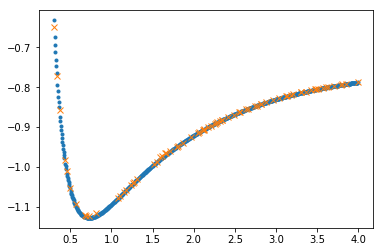

In [99]:
C_prd, E_prd = get_C_prd('H2_deep_test.ckpt', inp_test)
E_tar = np.array([inp.Et for inp in inp_train])
R_tar = np.array([inp.molecule.R[1,0] for inp in inp_train])
R_prd = np.array([inp.molecule.R[1,0] for inp in inp_test])

plt.plot(R_tar, E_tar, ls='', marker='.')
plt.plot(R_prd, E_prd, ls='', marker='x')

In [55]:
# def train(root_name='model', learn_rate=0.001, valid_ind=2, 
#           train_list=range(len(inp_grp)), print_step=5, from_scratch=False,
#           threshold=1E-5, maxiter=100000
#          ):

total_list = range(10)
tags = [str(i) for i in range(1, 10)]
inds = [total_list[:i] for i in range(1, 10)]

del tags[2]
del inds[2]

for i in range(len(tags)):
    tag = tags[i]
    ind = inds[i]
    train('increment_full_2-%s' % tag, 0.02, 2, ind, 10)